In [31]:
import sys
import numpy as np
sys.path.append('..')
%load_ext autoreload
%autoreload 2

# jax config
from jax import config
config.update("jax_enable_x64", True)

# plotting
import matplotlib.pyplot as plt
import numpy as np
from opentn.utils import set_discrete_labels
from opentn.transformations import create_kitaev_liouvillians, create_trotter_layers, super2ortho

# structure preserving methods
from opentn.structure_preserving import unnormalized_scheme

# optimization
from opentn.optimization import frobenius_norm, model_stiefel_local, get_kitaev_trotter_local_ansatz

# stiefel
from opentn.stiefel import gradient_stiefel_vec, riemannian_hessian_vec, retract_stiefel
from opentn.trust_region_rcopt import riemannian_trust_region_optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# TODO: move this to a unittest
from opentn.transformations import kraus2choi, choi2super, kraus2superop
A = np.random.rand(2,2)
B = np.random.rand(2,2)
kraus_list = [A, B]
op1 = choi2super(kraus2choi(kraus_list=kraus_list))
op2 = kraus2superop(kraus_list=kraus_list)
np.allclose(op1, op2)

True

# Let's do the same comparison for the kitaev wire. Let's say with $\tau = 1$ for now!

In [3]:
d, N, gamma = 2, 4, 1
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma, pbc=True)

In [206]:
# testing the individual parts to see what is going on
from opentn.structure_preserving import effective_hamiltonian, composition, unnormalized_scheme_error
from opentn.transformations import super2choi
from opentn.stiefel import is_hermitian, is_isometry_2


h_eff = effective_hamiltonian(lindbladians=Lnn, N=N, d=d, pbc=True)
print(is_hermitian(h_eff)) # but when taking away the 1/j it is hermitian as expected.

# lets evaluate the conditions of the final superoperator
superop_unnormalized = unnormalized_scheme(lindbladians=Lnn, N=N, d=d, timestep=1/1, order=1, quadrature='midpoint')
ortho = super2ortho(superop_unnormalized.real)
is_isometry_2(ortho)

(False, 1.3228756555322954)


False

In [192]:
np.linalg.norm(ortho.conj().T@ortho - np.eye(ortho.shape[1])) 
# also expected since it is an unormalized scheme
choi = super2choi(superop_unnormalized.real)
print(np.linalg.matrix_rank(choi))
np.linalg.eigvals(choi)[:8] # h at the end if this is hermitian
# TODO: also just if the choi matrix is hermitian

5


array([ 1.24375000e+01+0.j,  1.50000000e+00+0.j,  1.00000000e+00+0.j,
        5.00000000e-01+0.j,  1.00000000e+00+0.j,  5.25561615e-16+0.j,
       -1.81128360e-16+0.j, -2.47884975e-16+0.j])

In [246]:
tau = 1
number_timesteps = list(range(1,20))
timesteps = [tau/n for n in number_timesteps]
error_order_2 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=2) for n in number_timesteps]
error_order_1 = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=n, order=1) for n in number_timesteps]


In [208]:
taus = np.logspace(start=2, stop=-9, num=12, base=2)[::-1]
error_order_1_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=1) for tau in taus]
error_order_2_taus = [unnormalized_scheme_error(Lvec, Lnn, N, d, tau=tau, n=1, order=2) for tau in taus]

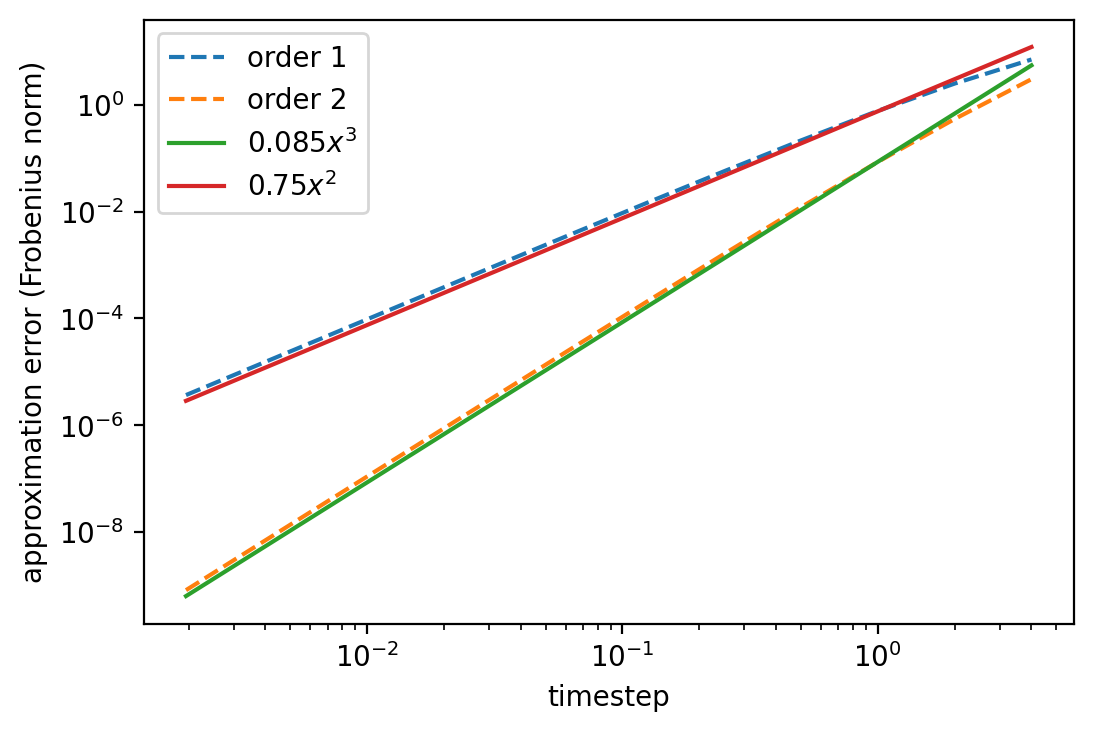

In [209]:
a  = 0.085
exponent = 3

b = 0.75
exponent_2 = 2
fig = plt.figure(dpi=200)
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('timestep')
plt.loglog(taus, error_order_1_taus, '--', label='order 1')
plt.loglog(taus, error_order_2_taus, '--', label='order 2')
plt.loglog(taus, a*np.array(taus, dtype=float)**(exponent), label=fr'${a} x^{exponent}$')
plt.loglog(taus, b*np.array(taus, dtype=float)**(exponent_2), label=fr'${b} x^{exponent_2}$')
plt.legend()

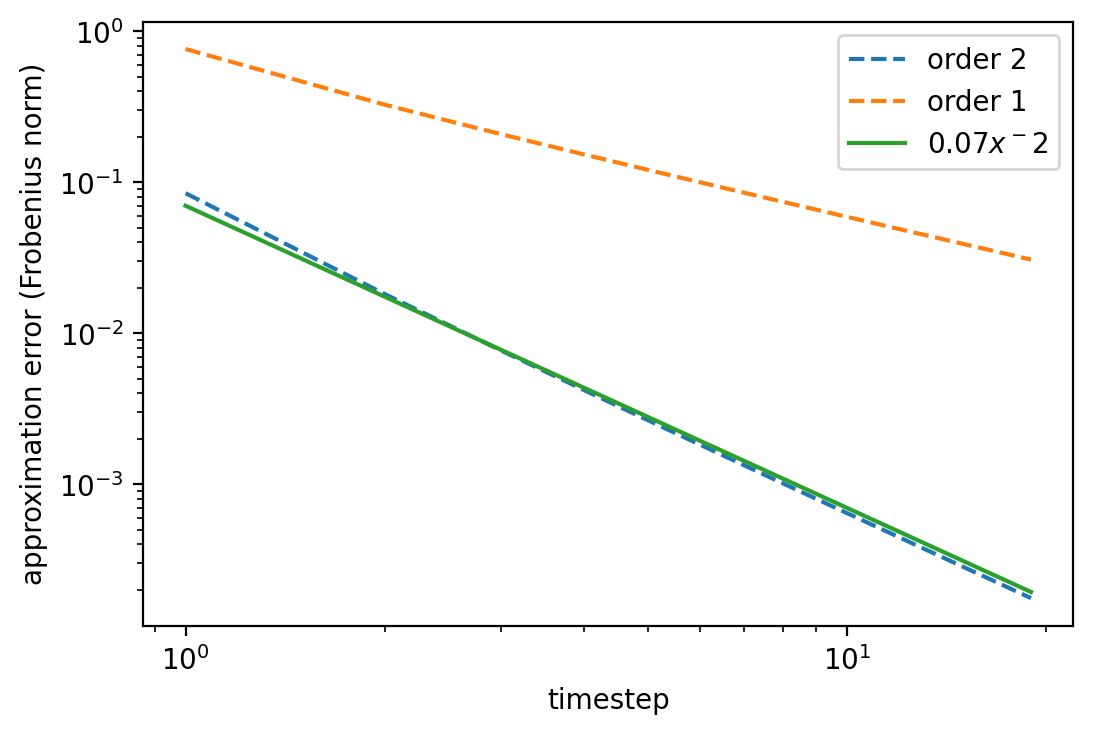

In [102]:
fig = plt.figure(dpi=200)
a = 0.07
exponent = -2
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('timestep')
plt.loglog(number_timesteps, error_order_2, '--', label='order 2')
plt.loglog(number_timesteps, error_order_1, '--', label='order 1')
plt.loglog(number_timesteps, a*np.array(number_timesteps, dtype=float)**(exponent), label=fr'${a} x^{exponent}$')
plt.legend()

# Comparing with the stiefel optimized

In [27]:
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers([Lvec, Lvec_odd, Lvec_even], tau=tau)
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d, ), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')

In [32]:
xs_timestep_1_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=1)]
xs_timestep_1_tau_1_opt, f_timestep_1_tau_1_opt, radius_timestep_1_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_tau_1, save_x=True, niter=10
)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.005992052805370799
radius 0.01
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.005179546089593455
radius 0.01
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.004968869961170965
radius 0.01
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.00496715711712558
radius 0.01
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.004967157113909462
radius 0.01
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 0.0025
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 0.000625
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 0.00015625
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 3.90625e-05
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.00496715711390933
radius 9.765625e-06


In [33]:
xs_timestep_2_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=2)]
xs_timestep_2_tau_1_opt, f_timestep_2_tau_1_opt, radius_timestep_2_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2_tau_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0015003228414415567
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0015003228414415567
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0012899560077915995
radius 0.005
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011963353491286884
radius 0.01
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011472388051221108
radius 0.0025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011472388051221108
radius 0.005
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0010822344505412636
radius 0.005
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0010526946205771715
radius 0.005
iteration: 8
column : 0
column : 1
column : 2
column :

In [34]:
xs_timestep_3_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=3)]
xs_timestep_3_tau_1_opt, f_timestep_3_tau_1_opt, radius_timestep_3_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_tau_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0006670002231771639
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0006670002231771639
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005597474477551285
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005060980689836066
radius 0.005
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0004657673579950943
radius 0.005
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0004484933170580338
radius 0.01
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0003786516418230549
radius 0.0025
iteration: 7
colu

In [243]:
xs_timestep_4_tau_1 = [super2ortho(x.real, rank=2) for x in get_kitaev_trotter_local_ansatz(gamma, tau, n=4)]
xs_timestep_4_tau_1_opt, f_timestep_4_tau_1_opt, radius_timestep_4_tau_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_4_tau_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.000375225044875735
radius 0.0025
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.000375225044875735
radius 0.0025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.00031554533579632415
radius 0.0025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0002746439079787677
radius 0.0025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.00023536959437316313
radius 0.005
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
column : 7
column : 8
cost function: 0.0002068539964610864
radius 0.00125
iteration: 6
column : 

In [244]:
error_nonoptimized_tau_1 = [values[0] for values in [f_timestep_1_tau_1_opt, f_timestep_2_tau_1_opt, f_timestep_3_tau_1_opt, f_timestep_4_tau_1_opt]]
error_stiefel_tau_1 = [values[-1] for values in [f_timestep_1_tau_1_opt, f_timestep_2_tau_1_opt, f_timestep_3_tau_1_opt, f_timestep_4_tau_1_opt]]

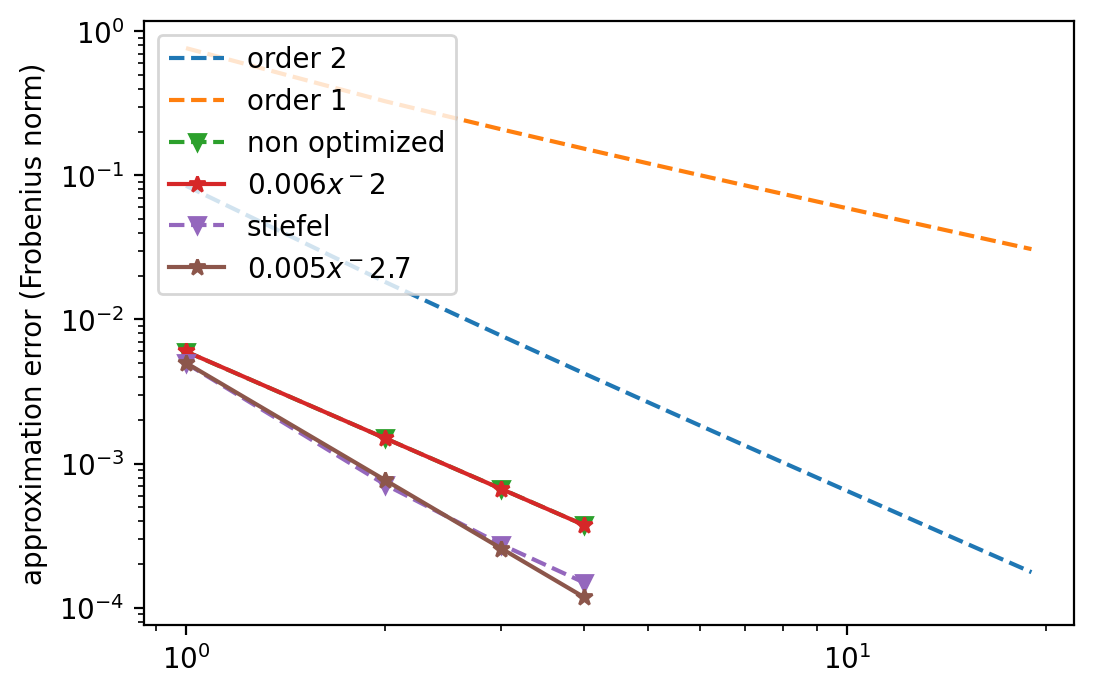

In [247]:
number_timesteps_stiefel = [1,2,3,4]
timesteps_stiefel = [tau/n for n in number_timesteps_stiefel]

fig = plt.figure(dpi=200)
plt.ylabel('approximation error (Frobenius norm)')
ax = plt.gca()
# plt.xlabel('timestep')

plt.loglog(number_timesteps, error_order_2, '--', label='order 2')
plt.loglog(number_timesteps, error_order_1, '--', label='order 1')

plt.loglog(number_timesteps_stiefel, error_nonoptimized_tau_1, '--v', label='non optimized')
exponent = -2
a = 0.006
plt.loglog(number_timesteps_stiefel, a*np.array(number_timesteps_stiefel, dtype=float)**(exponent), '-*' ,label=fr'${a} x^{exponent}$')

plt.loglog(number_timesteps_stiefel, error_stiefel_tau_1, '--v', label='stiefel')
exponent_2 = -2.7
b = 0.005
plt.loglog(number_timesteps_stiefel, b*np.array(number_timesteps_stiefel, dtype=float)**(exponent_2), '-*' ,label=fr'${b} x^{exponent_2}$')

plt.legend()

# Create random psd and use to compare the schemes

In [278]:
from opentn.stiefel import random_psd
from opentn.transformations import vectorize, unvectorize
from opentn.optimization import get_general_trotter_local_ansatz


def random_psd_error(superop_exact:np.ndarray, superops_error:list[np.ndarray], iterations:int=500, tol:float=1e-3, verbose:bool=False):
    """
    Calculate the averaged error when applying the superoperator of the different operators to a random psd operator
    """
    num_methods = len(superops_error)
    errors = np.zeros(shape=(iterations, num_methods)) 
    # create random instance:
    rows, cols = superop_exact.shape
    assert rows == cols, "this superop should be a square matrix" # Generalize this?

    for it in range(iterations):
        # sqrt since the superoperator dimensions are the original x conjugated
        rnd_psd = random_psd(dim=int(np.sqrt(rows)))
        rnd_psd_vec = vectorize(rnd_psd)
        # reference one
        vec_exact = superop_exact @ rnd_psd_vec
        
        for j, superop in enumerate(superops_error):
            # apply the superoperators from each scheme
            vec_scheme = superop @ rnd_psd_vec
            # normalize if necessary
            trace = np.trace(unvectorize(vec_scheme))
            if np.abs(trace - 1) >= tol:
                if verbose:
                    print('method no.: ', j)
                    print('unnormalized trace: ', trace)
                vec_scheme /= trace
            # save error of this iteraiton and operator
            errors[it,j] = frobenius_norm(unvectorize(vec_scheme), unvectorize(vec_exact))

    return np.mean(errors, axis=0)

In [281]:
num_timesteps_scheme = 20
superop_nonopt_ts = []
for n in range(1, num_timesteps_scheme + 1):
    xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=Lnn, tau=tau, n=n)]
    superop_nonopt_ts.append(model_stiefel_local(xs_trotter_ts, N, d))

xs_stiefel_ts = [xs_timestep_1_tau_1_opt, xs_timestep_2_tau_1_opt, xs_timestep_3_tau_1_opt, xs_timestep_4_tau_1_opt]


superop_stiefel_ts = [model_stiefel_local(xs[-1], N, d) for xs in xs_stiefel_ts]

superop_ord_1_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, timestep=tau/n, order=1), n=n) for n in range(1, num_timesteps_scheme + 1)]
superop_ord_2_ts = [composition(unnormalized_scheme(lindbladians=Lnn, N=N, d=d, timestep=tau/n, order=2), n=n) for n in range(1, num_timesteps_scheme + 1)]

error_nonopt = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts)
error_stiefel = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_stiefel_ts)
error_order_1 = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_1_ts)
error_order_2 = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_2_ts)
errors = [error_nonopt, error_stiefel, error_order_1, error_order_2]

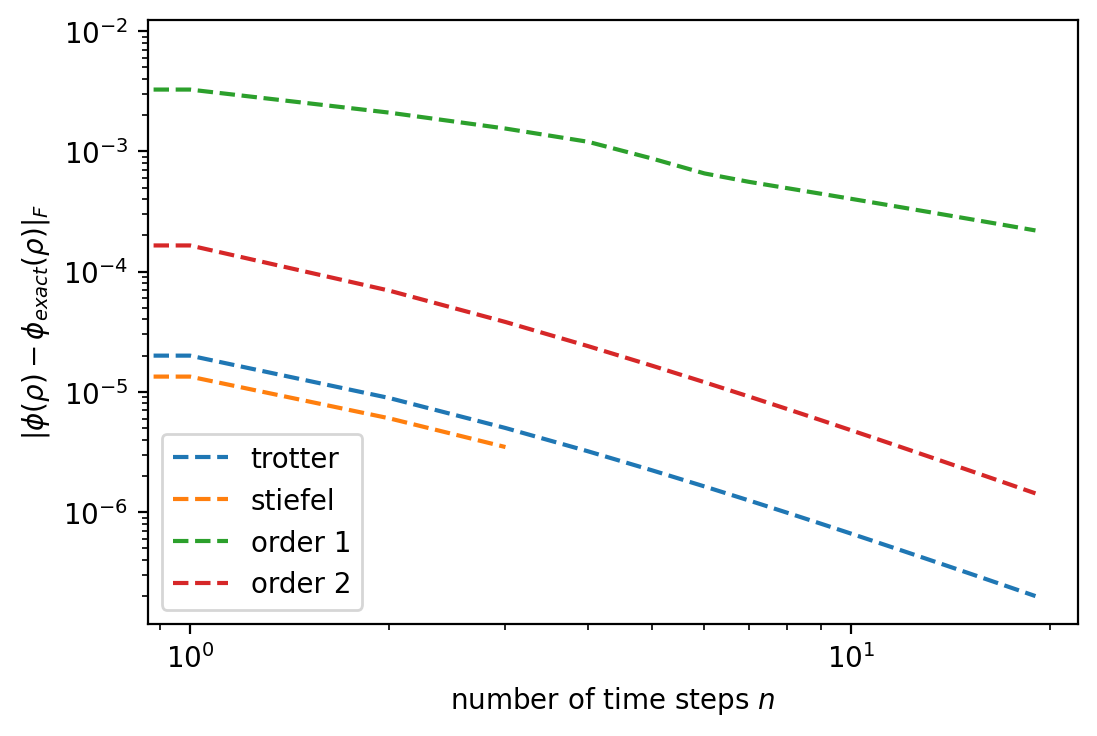

In [282]:
labels = ['trotter', 'stiefel', 'order 1', 'order 2']
fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi(\rho) - \phi_{exact}(\rho) \right|_F $')
plt.xlabel('number of time steps $n$')
for i in range(len(errors)):
    plt.loglog(errors[i], '--', label=labels[i])
plt.legend()
# set_discrete_labels(labels=[str(ts+1) for ts in range(num_timesteps_scheme)], rotation=0)


